In [1]:
setwd('/import/DB/workdir/cd40/')

In [9]:
sce = readRDS('/import/194.data/data/singledata/heart2/macro.rds')

In [10]:
library(Seurat)

In [11]:
Idents(sce) = 'orig.ident'

In [12]:
table(sce$orig.ident)


  MI14d    MI3d    MI7d control 
   1088    6617    3196     576 

In [14]:
wt7d = subset(sce,idents = 'MI7d')

In [15]:
DefaultAssay(wt7d) = 'RNA'

In [16]:
library(dplyr)

Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [17]:
expr <- wt7d@assays$RNA@data
gene_name <- c("Trem2")

In [18]:
gene_expression <- expr['Trem2',] %>% 
  #t() %>% 
  as.data.frame()

In [19]:
colnames(gene_expression) <- paste0(gene_name)
identical(colnames(wt7d),row.names(gene_expression))

[1] TRUE

In [23]:
wt7d <- AddMetaData(
       object = wt7d,
       metadata = gene_expression
   )

In [24]:
gene = wt7d@meta.data$Trem2

In [25]:
wt7d@meta.data$trem2.group=ifelse( gene> median(gene),'high','low') 

In [26]:
table(wt7d$trem2.group)


high  low 
1398 1798 

In [27]:
Idents(wt7d) = 'trem2.group'

In [28]:
diffgene  = FindMarkers(object = wt7d, ident.1 = 'high', min.pct = 0.25)

In [29]:
head(diffgene,1)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Trem2,0,3.279819,1,0,0


In [30]:
genelist <- as.numeric(diffgene[,2]) 
names(genelist) <- row.names(diffgene)

In [31]:
OrgDb = 'org.Mm.eg.db'

In [37]:
genelist_entrez <- genelist
names(genelist_entrez) <- bitr(names(genelist),
                               fromType="SYMBOL",toType="ENTREZID", 
                               OrgDb=OrgDb)[,2]  
genelist_entrez <- genelist_entrez[!is.na(names(genelist_entrez))]

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(names(genelist), fromType = "SYMBOL", toType = "ENTREZID", :
"1.99% of input gene IDs are fail to map..."


In [35]:
library(clusterProfiler)
library(org.Mm.eg.db)

In [36]:
library(enrichplot)
library(clusterProfiler)
library(org.Mm.eg.db)
library(DOSE)

In [38]:
geneList = genelist_entrez

In [39]:
gene <- names(geneList)

In [40]:
res2 <- enrichGO(gene, OrgDb = org.Mm.eg.db, ont = "BP")
res2 <- setReadable(res2, OrgDb = org.Mm.eg.db, keyType="ENTREZID")

In [41]:
ego <- enrichKEGG(
 gene          = gene,
 keyType     = "kegg",
 organism   = 'mmu',
 pvalueCutoff      = 0.05,
 pAdjustMethod     = "BH",
 qvalueCutoff  = 0.05
)

Reading KEGG annotation online: "https://rest.kegg.jp/link/mmu/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/mmu"...



In [42]:
ego2 <- setReadable(ego, OrgDb = org.Mm.eg.db, keyType="ENTREZID")

In [43]:
grep('Spp1',ego2@result$geneID)

[1]  24  27  33  42  61 139 171

In [44]:
res = ego2@result[c(24,27,33,42,61,139,171),]

In [45]:
write.csv(res,file = 'trem2.7d.kegg.res.csv')

In [46]:
ego2@result = res

In [47]:
options(repr.plot.width = 12,repr.plot.height = 5)

In [48]:
 library (stringr)

Warning message:
"package 'stringr' was built under R version 4.2.3"


In [49]:
ego2@result$Description <- gsub(pattern = " - Mus musculus (house mouse)", replacement = "", ego2@result$Description, fixed = T)

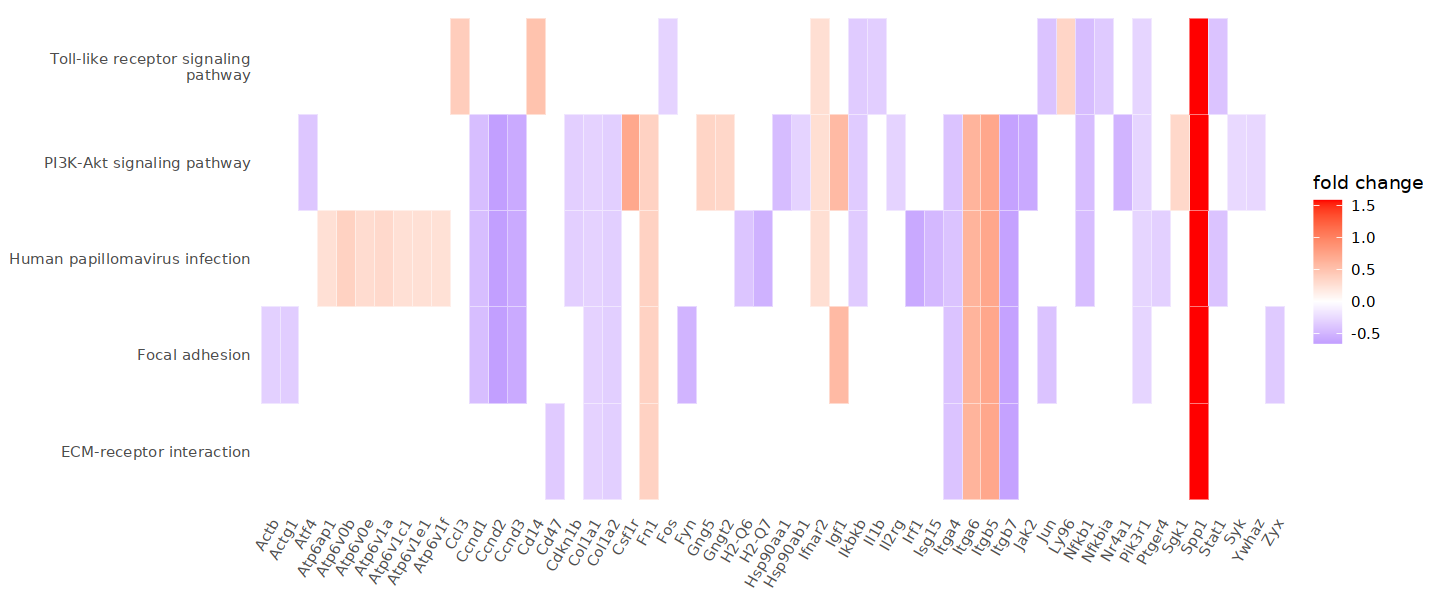

In [50]:
heatplot(ego2, foldChange=genelist)

In [60]:
getwd()

[1] "/import/DB/workdir/cd40"

In [51]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


In [52]:
ggsave('trem2.7d.heatplot.pdf',width = 12,height = 5)

In [57]:
options(repr.plot.width = 15,repr.plot.height = 15)

Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version."
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Warning message:
"ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


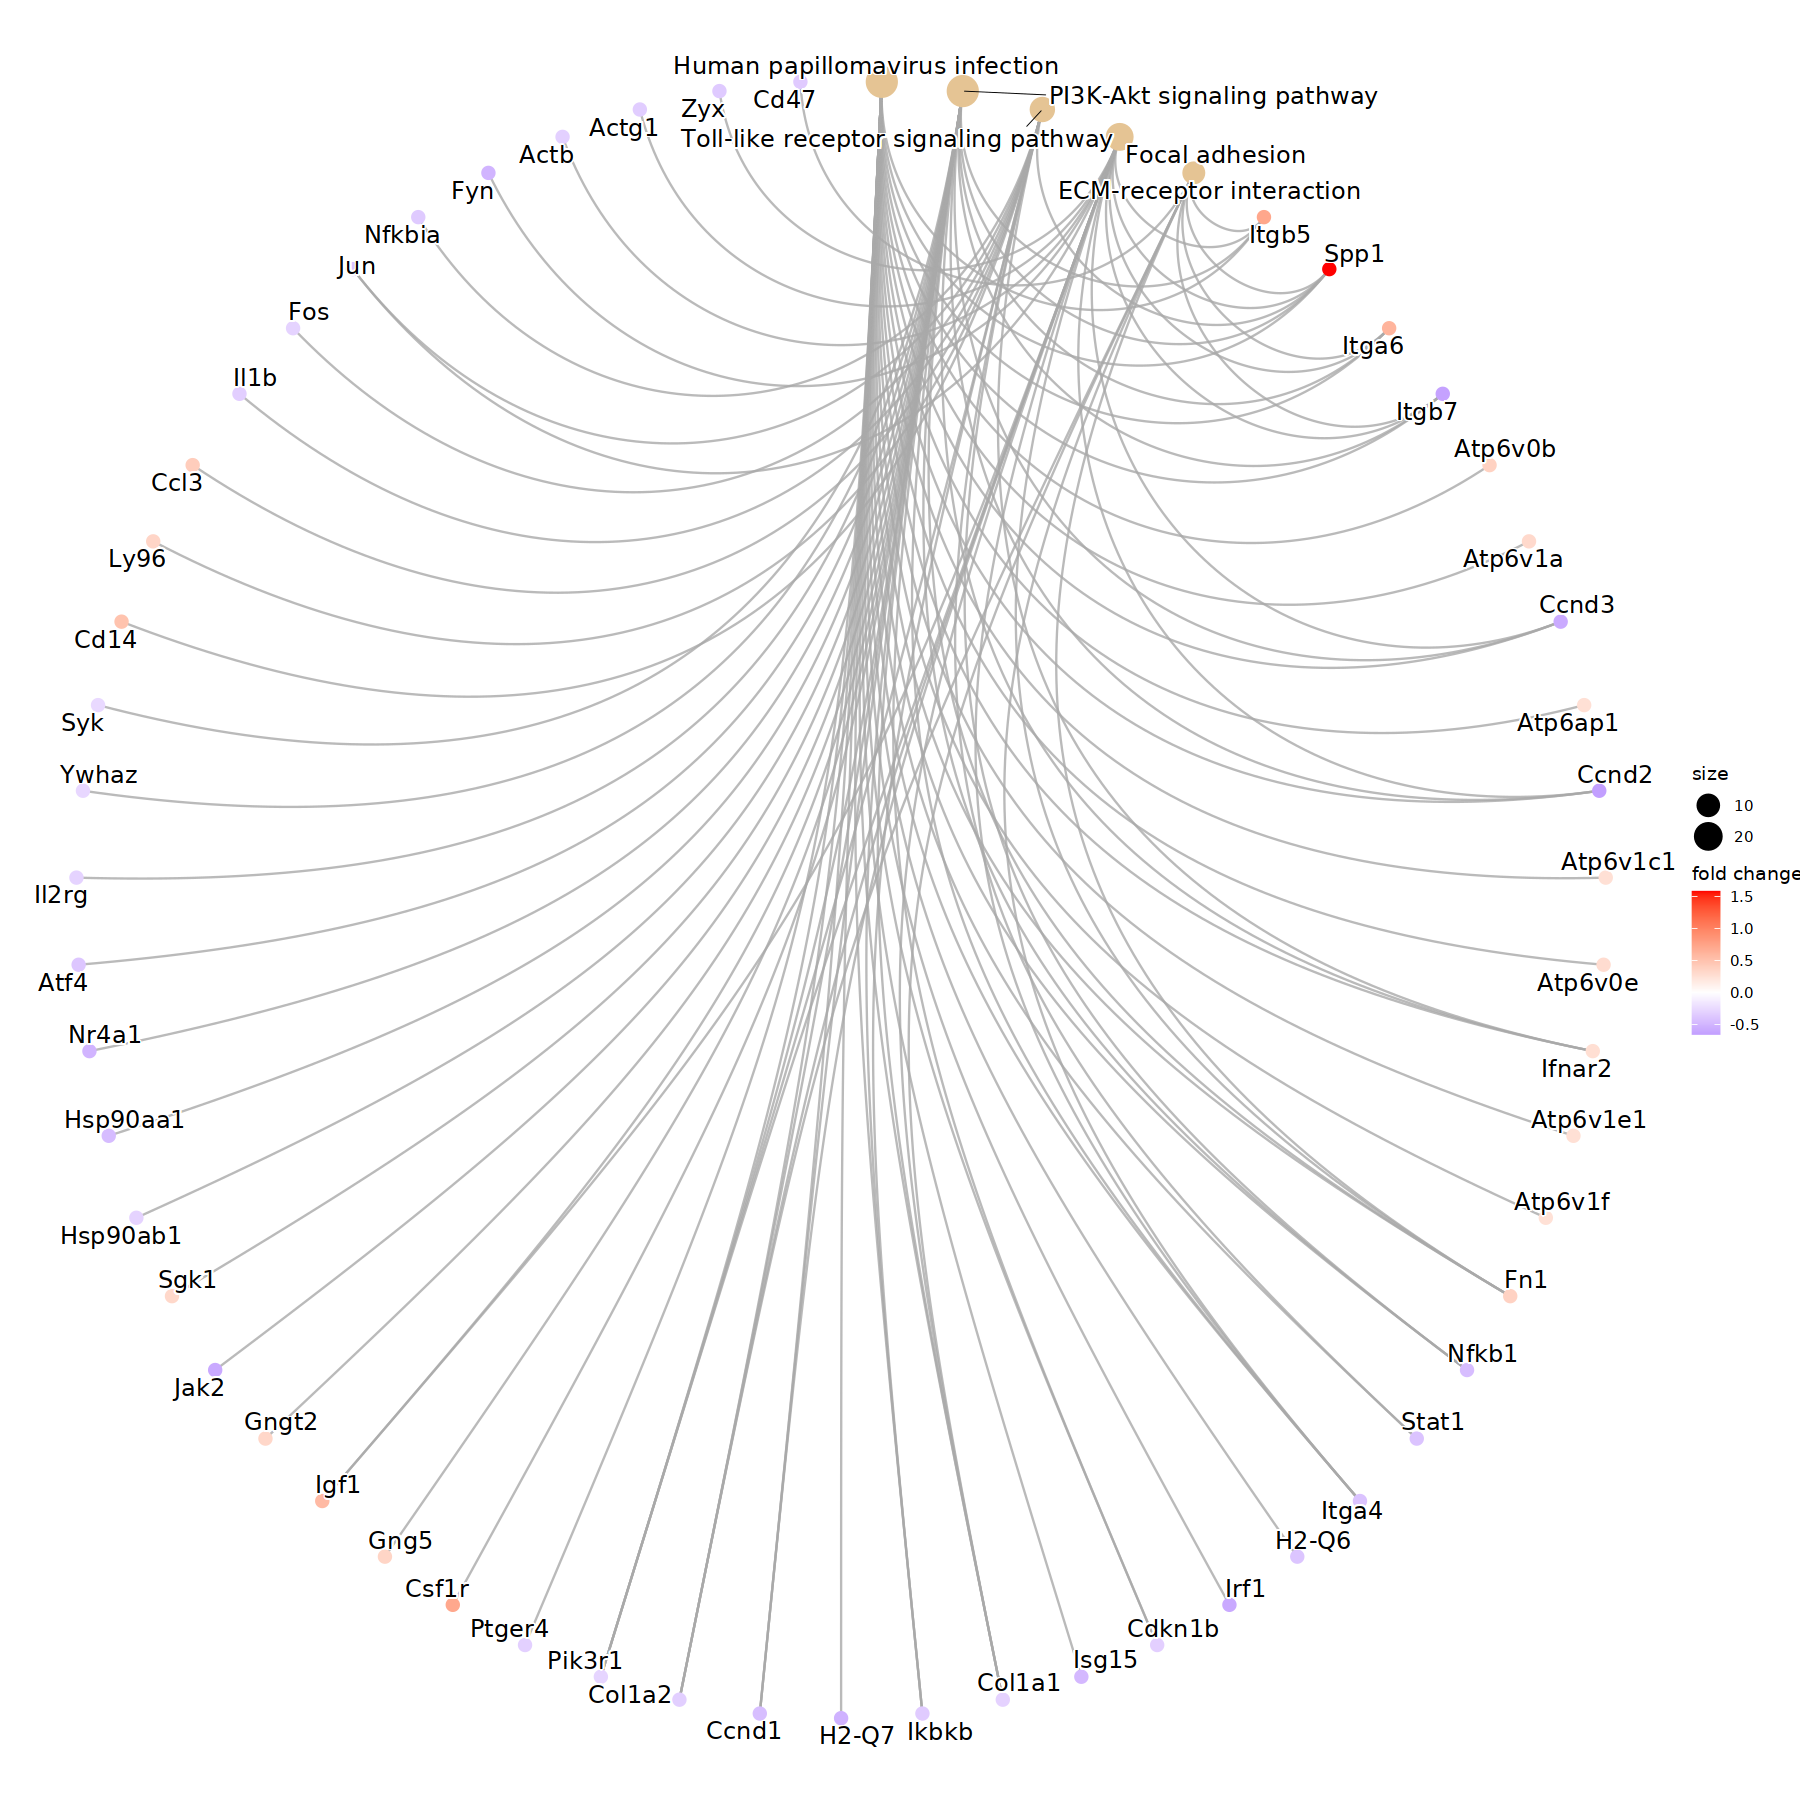

In [58]:
cnetplot(ego2, foldChange=genelist,showCategory = 8, circular = T,max.overlaps = 500)

In [59]:
ggsave('trem2.7d.circplot.pdf',width = 15,height = 15)